# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import time
import seaborn as sns
from matplotlib import pyplot as plt

% matplotlib inline

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Cleaning

# Portfolio

In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
# clean portfolio dataframe
print('There are {} offer portfolios'.format(portfolio.shape[0]))
offer = portfolio.copy()
dummy = pd.get_dummies(offer.channels.apply(pd.Series).stack()).sum(level=0)
offer = pd.concat([offer, dummy], axis=1)
offer['channels'] = offer['channels'].apply('_'.join)
#offer['offer_pkg'] = offer.astype(str)[['offer_type','difficulty','reward','duration','channels']].agg('-'.join,axis=1)
offer['duration_hrs'] = offer['duration']*24
offer

There are 10 offer portfolios


,channels,difficulty,duration,id,offer_type,reward,email,mobile,social,web,duration_hrs
0,email_mobile_social,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,168
1,web_email_mobile_social,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,120
2,web_email_mobile,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,96
3,web_email_mobile,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,168
4,web_email,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,240
5,web_email_mobile_social,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1,168
6,web_email_mobile_social,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1,240
7,email_mobile_social,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0,72
8,web_email_mobile_social,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,120
9,web_email_mobile,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1,168


# Profile

In [5]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [6]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [7]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [8]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

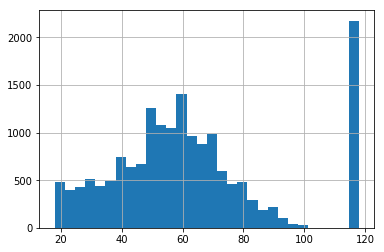

In [9]:
profile.age.hist(bins =30);

In [10]:
profile.loc[profile.age >100,'age'].value_counts()

118    2175
101       5
Name: age, dtype: int64

There are 2175 rows have missing value, which are about 13% of the dataset. To make the most of the dataset, replace the age and income missing values with medians and gender with the mode. 


In [11]:
# clean profile dataframe
print('There are {} users in total in profiles'.format(profile.shape[0]))
profile.gender.fillna(value=np.nan, inplace=True)
profile.age.replace(118, np.nan, inplace=True)
profile.became_member_on = pd.to_datetime(profile.became_member_on.astype(str), format="%Y/%m/%d").dt.year
profile.head()

There are 17000 users in total in profiles


,age,became_member_on,gender,id,income
0,NaN,2017,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55.0,2017,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,NaN,2018,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75.0,2017,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,NaN,2017,NaN,a03223e636434f42ac4c3df47e8bac43,NaN


We will need user profile variables as input to recommend which offer (or no offer) to provide.The null-data user group only has member-since date and offer behavior, who will be less accurately predicted. From data cleaning perspective, we will transfer them into categorical variables, so NA could be identified by model. Keep all the records but add a tag to identifies which rows are for further analysis.

# Transcript

In [12]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [13]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [14]:
#An individual customer example
transcript.loc[transcript['person']=='78afa995795e4d85b5d9ceeca43f5fef',]

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89}
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78}
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,{'amount': 19.67}
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,{'amount': 29.72}
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,{'amount': 23.93}


In [15]:
# clean transcript dataframe
# deal with dictionary data in variables
#start_time = time.time()
value_split = transcript['value'].apply(pd.Series)
#end_time = time.time()
#print(end_time-start_time)
# combine duplicated columns 'offer id' and 'offer_id'
value_split['offer_id'] = value_split['offer_id'].combine_first(value_split['offer id'])
# concatenate with other transcript columns (reward is not needed given it's included in offer features)
trans = pd.concat([transcript.drop(columns = 'value'),value_split[['offer_id','amount']]],axis=1)

In [16]:
#merge with portfolio and profile
trans = trans.merge(profile,how='left',left_on=['person'], right_on=['id']).merge(offer,how='left',
        left_on=['offer_id'], right_on=['id']).drop(['id_x','id_y'], axis=1)

In [17]:
trans.head().transpose()

,0,1,2,3,4
event,offer received,offer received,offer received,offer received,offer received
person,78afa995795e4d85b5d9ceeca43f5fef,a03223e636434f42ac4c3df47e8bac43,e2127556f4f64592b11af22de27a7932,8ec6ce2a7e7949b1bf142def7d0e0586,68617ca6246f4fbc85e91a2a49552598
time,0,0,0,0,0
offer_id,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2906b810c7d4411798c6938adc9daaa5,fafdcd668e3743c1bb461111dcafc2a4,4d5c57ea9a6940dd891ad53e9dbe8da0
amount,NaN,NaN,NaN,NaN,NaN
age,75,NaN,68,NaN,NaN
became_member_on,2017,2017,2018,2017,2017
gender,F,NaN,M,NaN,NaN
income,100000,NaN,70000,NaN,NaN
channels,web_email_mobile,web_email,web_email_mobile,web_email_mobile_social,web_email_mobile_social


In [18]:
# split offer status and transaction amount
trans_offer = trans.loc[trans['offer_id'].notna()]
trans_amount = trans.loc[trans['amount'].notna()]
print(trans.shape,trans_offer.shape,trans_amount.shape)

(306534, 19) (167581, 19) (138953, 19)


In [19]:
trans_amount=trans_amount.loc[:,['person','amount','offer_type']]
trans_amount.head()

,person,amount,offer_type
12654,02c083884c7d45b39cc68e1314fec56c,0.83,NaN
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,34.56,NaN
12659,54890f68699049c2a04d415abc25e717,13.23,NaN
12670,b2f1cd155b864803ad8334cdf13c4bd2,19.51,NaN
12671,fe97aa22dd3e48c8b143116a8403dd52,18.97,NaN


In [20]:
#Rollup offer received by customer
person_offer_received = trans_offer.loc[trans_offer.event=='offer received',['person','event','offer_type']].groupby(['person',
                        'offer_type']).count().reset_index()
person_offer_received = person_offer_received.rename(columns = {'event':'offer_received'})
#Rollup offer viewed by customer
person_offer_viewed = trans_offer.loc[trans_offer.event=='offer viewed',['person','event','offer_type']].groupby(['person',
                        'offer_type']).count().reset_index()
person_offer_viewed = person_offer_viewed.rename(columns = {'event':'offer_viewed'})
#Rollup offer completed by customer
person_offer_completed = trans_offer.loc[(trans_offer.event=='offer completed'),['person','event','offer_type']].groupby(['person',
                        'offer_type']).count().reset_index()
person_offer_completed = person_offer_completed.rename(columns = {'event':'offer_completed'})

In [21]:
profile_Clean = profile.rename(columns = {'id':'person'})

In [22]:
trans_offer_rollup = profile_Clean.merge(person_offer_received,how='left',on=['person']).merge(person_offer_viewed,
                      how='left',on=['person','offer_type']).merge(person_offer_completed,how='left',on=['person',
                      'offer_type']).merge(trans_amount,how='left',on=['person','offer_type'])

In [23]:
trans_offer_rollup .head()

,age,became_member_on,gender,person,income,offer_type,offer_received,offer_viewed,offer_completed,amount
0,NaN,2017,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,discount,5.0,5.0,2.0,NaN
1,55.0,2017,F,0610b486422d4921ae7d2bf64640c50b,112000.0,bogo,1.0,NaN,1.0,NaN
2,55.0,2017,F,0610b486422d4921ae7d2bf64640c50b,112000.0,informational,1.0,NaN,NaN,NaN
3,NaN,2018,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,bogo,1.0,1.0,NaN,NaN
4,NaN,2018,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,informational,1.0,1.0,NaN,NaN


In [24]:
trans_offer_rollup.describe()

,age,became_member_on,income,offer_received,offer_viewed,offer_completed,amount
count,35343.000000,40504.000000,35343.000000,40484.000000,34935.000000,19552.000000,20.000000
mean,54.460685,2016.635172,65390.770450,1.884127,1.652354,1.717420,12.530500
std,17.420522,1.178635,21606.753413,0.938273,0.822044,0.868105,9.577654
min,18.000000,2013.000000,30000.000000,1.000000,1.000000,1.000000,0.350000
25%,42.000000,2016.000000,49000.000000,1.000000,1.000000,1.000000,4.340000
50%,55.000000,2017.000000,63000.000000,2.000000,1.000000,1.000000,10.625000
75%,67.000000,2017.000000,80000.000000,2.000000,2.000000,2.000000,18.985000
max,101.000000,2018.000000,120000.000000,6.000000,6.000000,6.000000,28.700000


In [25]:
#Add in the View Through Rate and Conversion Rate
trans_offer_rollup['offer_VTR'] =trans_offer_rollup.offer_viewed/trans_offer_rollup.offer_received
trans_offer_rollup['offer_CVR'] =trans_offer_rollup.offer_completed/trans_offer_rollup.offer_viewed
trans_offer_rollup= trans_offer_rollup.fillna(0)
trans_offer_rollup.head().transpose()

,0,1,2,3,4
age,0,55,55,0,0
became_member_on,2017,2017,2017,2018,2018
gender,0,F,F,0,0
person,68be06ca386d4c31939f3a4f0e3dd783,0610b486422d4921ae7d2bf64640c50b,0610b486422d4921ae7d2bf64640c50b,38fe809add3b4fcf9315a9694bb96ff5,38fe809add3b4fcf9315a9694bb96ff5
income,0,112000,112000,0,0
offer_type,discount,bogo,informational,bogo,informational
offer_received,5,1,1,1,1
offer_viewed,5,0,0,1,1
offer_completed,2,1,0,0,0
amount,0,0,0,0,0


# Data Exploration

First Understand the distribution and interaction of the features in customer profiles.

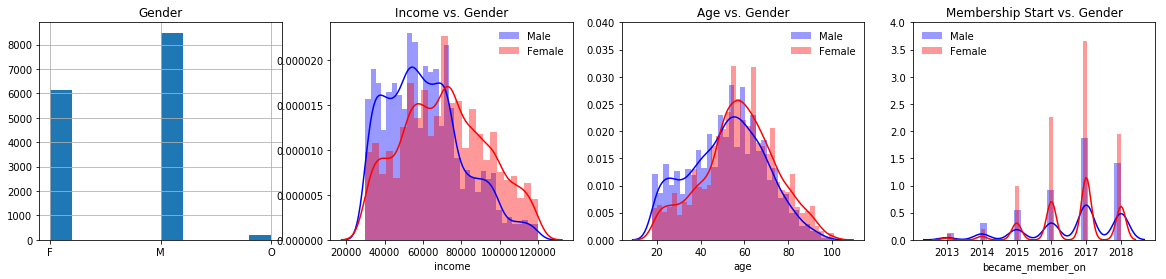

In [26]:
plt.subplots(figsize=(20, 4));

plt.subplot(1,4,1)
profile.gender.hist();
plt.title('Gender')

plt.subplot(1,4,2)
sns.distplot(profile.loc[profile.gender=='M','income'],color="b");
sns.distplot(profile.loc[profile.gender=='F','income'],color="r");
plt.title('Income vs. Gender')
plt.legend(['Male','Female'],frameon=False);

plt.subplot(1,4,3)
sns.distplot(profile.loc[profile.gender=='M','age'],color="b");
sns.distplot(profile.loc[profile.gender=='F','age'],color="r");
plt.title('Age vs. Gender')
plt.legend(['Male','Female'],frameon=False);
plt.ylim(0, 0.04);

plt.subplot(1,4,4)
sns.distplot(profile.loc[profile.gender=='M','became_member_on'],color="b");
sns.distplot(profile.loc[profile.gender=='F','became_member_on'],color="r");
plt.title('Membership Start vs. Gender')
plt.legend(['Male','Female'],frameon=False);
plt.ylim(0, 4);


1. There are 38% more Male customers than female customers. 
2. Male customers are right skewed while female customers are more evenly distributed by income. Average income is 65405.
3. Average male customers are younger than average female customers. The total cutomer profolio is 62..5 years old.
4. Most customers became member on 2016 to 2018 with much more new female customers. 

Then understand the interaction between the customer profile feature and offer incluences

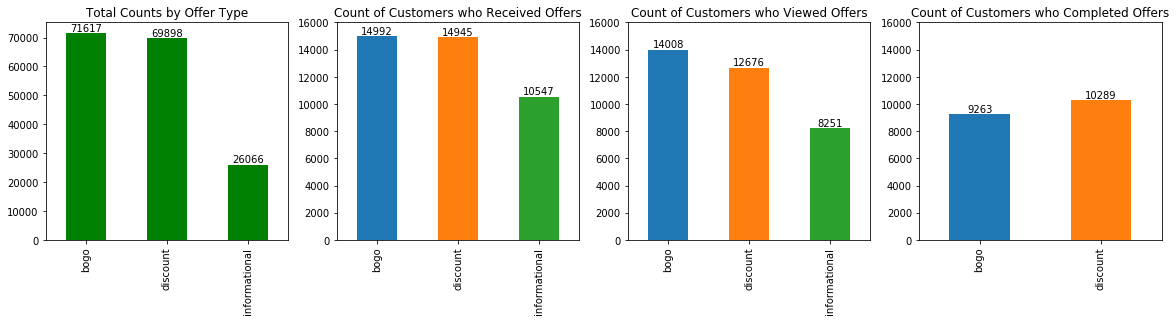

In [27]:
plt.subplots(figsize=(20, 4));

plt.subplot(1,4,1)
frequency = trans.loc[trans.offer_type != 0 ,'offer_type'].value_counts()
frequency.plot.bar(color='green');
plt.title("Total Counts by Offer Type");
for i, event_num in enumerate(frequency):
    plt.text(i, event_num, event_num, ha = 'center', va = 'bottom');

plt.subplot(1,4,2)
OfferReceived_byoffertype =trans_offer_rollup[trans_offer_rollup.offer_received > 0 ].groupby('offer_type').offer_received.count()
OfferReceived_byoffertype.plot.bar();
plt.title("Count of Customers who Received Offers");
for i, event_num in enumerate(OfferReceived_byoffertype):
    plt.text(i, event_num, event_num, ha = 'center', va = 'bottom');
plt.xlabel("");
plt.ylim(0, 16000);

plt.subplot(1,4,3)
VTR_byoffertype = trans_offer_rollup[trans_offer_rollup.offer_viewed > 0 ].groupby('offer_type').offer_viewed.count()
VTR_byoffertype.plot.bar();
plt.title("Count of Customers who Viewed Offers");
for i, event_num in enumerate(VTR_byoffertype):
    plt.text(i, event_num, event_num, ha = 'center', va = 'bottom');
plt.xlabel("");
plt.ylim(0, 16000);

plt.subplot(1,4,4)
CTR_byoffertype = trans_offer_rollup[trans_offer_rollup.offer_completed > 0 ].groupby('offer_type').offer_completed.count()
CTR_byoffertype.plot.bar();
plt.title("Count of Customers who Completed Offers");
for i, event_num in enumerate(CTR_byoffertype):
    plt.text(i, event_num, event_num, ha = 'center', va = 'bottom');
plt.xlabel("");
plt.ylim(0, 16000);

While both bogo and discount offers are almost evenly distributed to customer in the sense of total amount and 10% fewer customers viewed discount offers than bogo offers, 11% more discount offers are completed. 

# Modeling

Data Processing

In [28]:
#Filling the missing Gender using the mode; filling the age and income using the Median
values = {'gender': trans.gender.mode()[0]}
trans_offer_rollup.fillna(value=values, inplace=True)
imputer = Imputer(strategy='median')
imputed = imputer.fit_transform(trans_offer_rollup[['age', 'income']])
trans_offer_rollup[['age', 'income']] = pd.DataFrame(imputed, columns=['age', 'income'])
trans_offer_rollup.drop(['person'], axis=1, inplace=True)
trans_offer_rollup.head().T

,0,1,2,3,4
age,0,55,55,0,0
became_member_on,2017,2017,2017,2018,2018
gender,0,F,F,0,0
income,0,112000,112000,0,0
offer_type,discount,bogo,informational,bogo,informational
offer_received,5,1,1,1,1
offer_viewed,5,0,0,1,1
offer_completed,2,1,0,0,0
amount,0,0,0,0,0
offer_VTR,1,0,0,1,1


In [29]:
#Check if there is missing value after the replacement:
trans_offer_rollup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40504 entries, 0 to 40503
Data columns (total 11 columns):
age                 40504 non-null float64
became_member_on    40504 non-null int64
gender              40504 non-null object
income              40504 non-null float64
offer_type          40504 non-null object
offer_received      40504 non-null float64
offer_viewed        40504 non-null float64
offer_completed     40504 non-null float64
amount              40504 non-null float64
offer_VTR           40504 non-null float64
offer_CVR           40504 non-null float64
dtypes: float64(8), int64(1), object(2)
memory usage: 3.7+ MB


In [30]:
#One-Hot Encoding
trans_ohe = pd.get_dummies(trans_offer_rollup, columns=['became_member_on','gender','offer_type']).fillna(0)
trans_ohe.head().T

,0,1,2,3,4
age,0.0,55.0,55.0,0.0,0.0
income,0.0,112000.0,112000.0,0.0,0.0
offer_received,5.0,1.0,1.0,1.0,1.0
offer_viewed,5.0,0.0,0.0,1.0,1.0
offer_completed,2.0,1.0,0.0,0.0,0.0
amount,0.0,0.0,0.0,0.0,0.0
offer_VTR,1.0,0.0,0.0,1.0,1.0
offer_CVR,0.4,0.0,0.0,0.0,0.0
became_member_on_2013,0.0,0.0,0.0,0.0,0.0
became_member_on_2014,0.0,0.0,0.0,0.0,0.0


In [31]:
# Feature Scaling
scaler = StandardScaler().fit(trans_ohe) 
trans_scaled = scaler.transform(trans_ohe)

#checking scaling results
trans_scaled.std(axis=0)[:5],trans_scaled.mean(axis=0)[:5]

(array([ 1.,  1.,  1.,  1.,  1.]),
 array([ -4.38563312e-17,  -1.75425325e-17,   1.18675232e-16,
          8.87652144e-17,   3.66638929e-17]))

Text(0.5,1,'Explained Variance Per Principal Component & Cumulative')

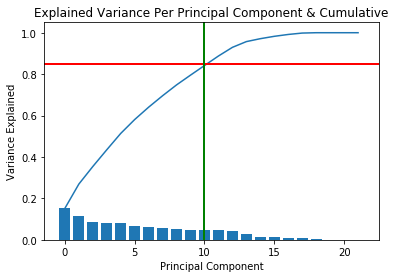

In [32]:
# PCA 
pca = PCA()
X_pca = pca.fit_transform(trans_scaled)

num_components=len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_
 
plt.figure()
ax = plt.subplot()
cumvals = np.cumsum(vals)
ax.bar(ind, vals)
ax.plot(ind, cumvals)
ax.axhline(y=0.85, linewidth=2, color='r');
ax.axvline(x=10, linewidth=2, color='g');

ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance Explained")
plt.title('Explained Variance Per Principal Component & Cumulative')

10 components together explained about 85% of variance

In [33]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(10).fit(trans_scaled)
starbucks_pca = pca.transform(trans_scaled)
starbucks_pca.shape

(40504, 10)

Run K-means

In [34]:
sse = []
since = time.time()

for k in  range(1, 16):
    print("calculating {} clusters".format(k))
    clusterer = KMeans(n_clusters=k, n_init=100, init='k-means++').fit(starbucks_pca)   
    sse.append(clusterer.inertia_)
    print("sum of squared distances:", clusterer.inertia_)
          
time.time() - since


calculating 1 clusters
sum of squared distances: 708647.168442
calculating 2 clusters
sum of squared distances: 611673.837879
calculating 3 clusters
sum of squared distances: 529076.179141
calculating 4 clusters
sum of squared distances: 463159.990982
calculating 5 clusters
sum of squared distances: 418668.915459
calculating 6 clusters
sum of squared distances: 387610.319884
calculating 7 clusters
sum of squared distances: 364701.40123
calculating 8 clusters
sum of squared distances: 345720.655276
calculating 9 clusters
sum of squared distances: 325054.752968
calculating 10 clusters
sum of squared distances: 307202.877738
calculating 11 clusters
sum of squared distances: 294613.832497
calculating 12 clusters
sum of squared distances: 283568.706692
calculating 13 clusters
sum of squared distances: 272201.949951
calculating 14 clusters
sum of squared distances: 261705.010826
calculating 15 clusters
sum of squared distances: 250222.809296


177.8940773010254

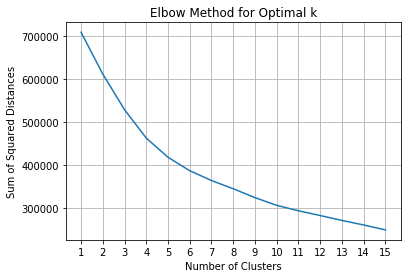

In [35]:
plt.plot(range(1, 16), sse)
plt.xlabel('Number of Clusters')
plt.xticks(range(1, 16))
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k')
plt.grid();

despite the smooth elbow plot, the slope at 3 is sharper than at 2 and 4. So fitting 3 clusters:

In [36]:
clusterer = KMeans(n_clusters=3, n_init=100, init='k-means++').fit(starbucks_pca)
starbucks_preds = clusterer.predict(starbucks_pca)

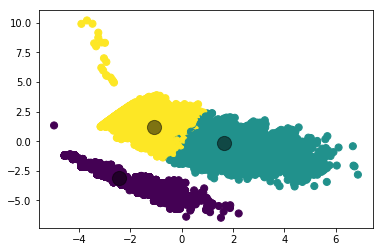

In [37]:
plt.scatter(starbucks_pca[:, 0], starbucks_pca[:, 1], c=starbucks_preds, s=50, cmap='viridis')
centers = clusterer.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

Model Interpretation

In [38]:
pca_inversed = pca.inverse_transform(clusterer.cluster_centers_[0, :])
scaler_inversed = np.around(scaler.inverse_transform(pca_inversed), decimals=2)
cluster_df = pd.DataFrame(scaler_inversed, trans_ohe.columns)
cluster_df.drop(0, axis=1, inplace=True)

for i in range(3):
    pca_inversed = pca.inverse_transform(clusterer.cluster_centers_[i, :])
    scaler_inversed = np.around(scaler.inverse_transform(pca_inversed), decimals=2)
    cluster_df['cluster_'+str(i+1)]= pd.DataFrame(scaler_inversed, trans_ohe.columns)
    
means = []
for each in trans_ohe.columns:
    mean = round(trans_ohe[each].mean(), 2)
    means.append(mean)
    
means_df = pd.DataFrame(means, index=cluster_df.index, columns=['means'])

cluster_df_fin = cluster_df.merge(means_df, on=cluster_df.index)
cluster_df_fin.index = cluster_df_fin.key_0
cluster_df_fin.drop('key_0', axis=1, inplace=True)
cluster_df_fin

,cluster_1,cluster_2,cluster_3,means
key_0,,,,
age,-4.61,56.14,54.01,47.52
income,-5489.56,68732.78,63366.07,57058.71
offer_received,1.93,2.36,1.34,1.88
offer_viewed,1.55,1.89,0.87,1.43
offer_completed,0.16,1.68,0.09,0.83
amount,-0.00,-0.00,0.02,0.01
offer_VTR,0.80,0.82,0.67,0.76
offer_CVR,0.08,0.91,0.10,0.47
became_member_on_2013,0.01,0.02,0.02,0.02


# Cluster Groups

Cluster_1 Highly incentivized group: This group of customers have the highest income at around 69K with a balanced mix of gender. Most of them become member in 2016 and 2017. With an average CVR at 91% and VTR at 82%, this group of customers are highly responsive to the offers but not so much with advertisements.  

Cluster_2 Advertisement attracted group: This group of customers are more attracted to view the offers, especially like to open up the advertisement ones. This group of customers are mostly male and are new customers that became member in 2017 and 2018.  They also tend to spend more. Combined with a low CVR, this group of customers are not prone to discount and bogo offers and tend to consume without marketing offers. So this group of customers are more suited to send advertisements to. 

Cluster_3 Potential customers group: This group of customers don't like to provide full personal profile information so didn't fill in gender, income or age when signing up. However, they are also more likely to be incentivized by the discount and bogo offers. This is a group of customers that are more cautious when making consumptions and have the potential to be attracted by marketing campaigns. This group is a great target segment to expend marketing campaign influence. 